# Data PreProcessing

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [5]:
yaw_df = pd.read_csv('/content/scaled_features_avgComposed.csv')
data_df = pd.read_csv('/content/scaled_features.csv')

In [7]:
rollpitch_df = pd.read_csv('/content/scaled_features_arctanComposed.csv')

In [8]:
X = data_df.drop(['yaw','pitch','roll'],axis=1)
y = data_df[['pitch','yaw','roll']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

after we take average of x and y we represent each feature in one number so we can use PCA to reduce the number of feature and see it's affection

In [9]:
Xy = yaw_df.drop(['yaw','pitch','roll'],axis=1)
yy = yaw_df[['pitch','yaw','roll']]
Xy_train, Xy_test, yy_train, yy_test = train_test_split(Xy, yy, test_size=0.20, random_state=42)
scaler = StandardScaler()
# Xy_train = scaler.fit_transform(Xy_train)
# Xy_test = scaler.transform(Xy_test)
pca = PCA(0.95)
Xy_train_c = pca.fit_transform(scaler.fit_transform(Xy_train))
Xy_test_c = pca.transform(scaler.transform(Xy_test))
Xy_train_c.shape

(1482, 3)

After PCA we can now visualize the produced Data and from it we see that we can first try fitting the data with linear model but it will be with high margin of error may SVR be better will see in the model section

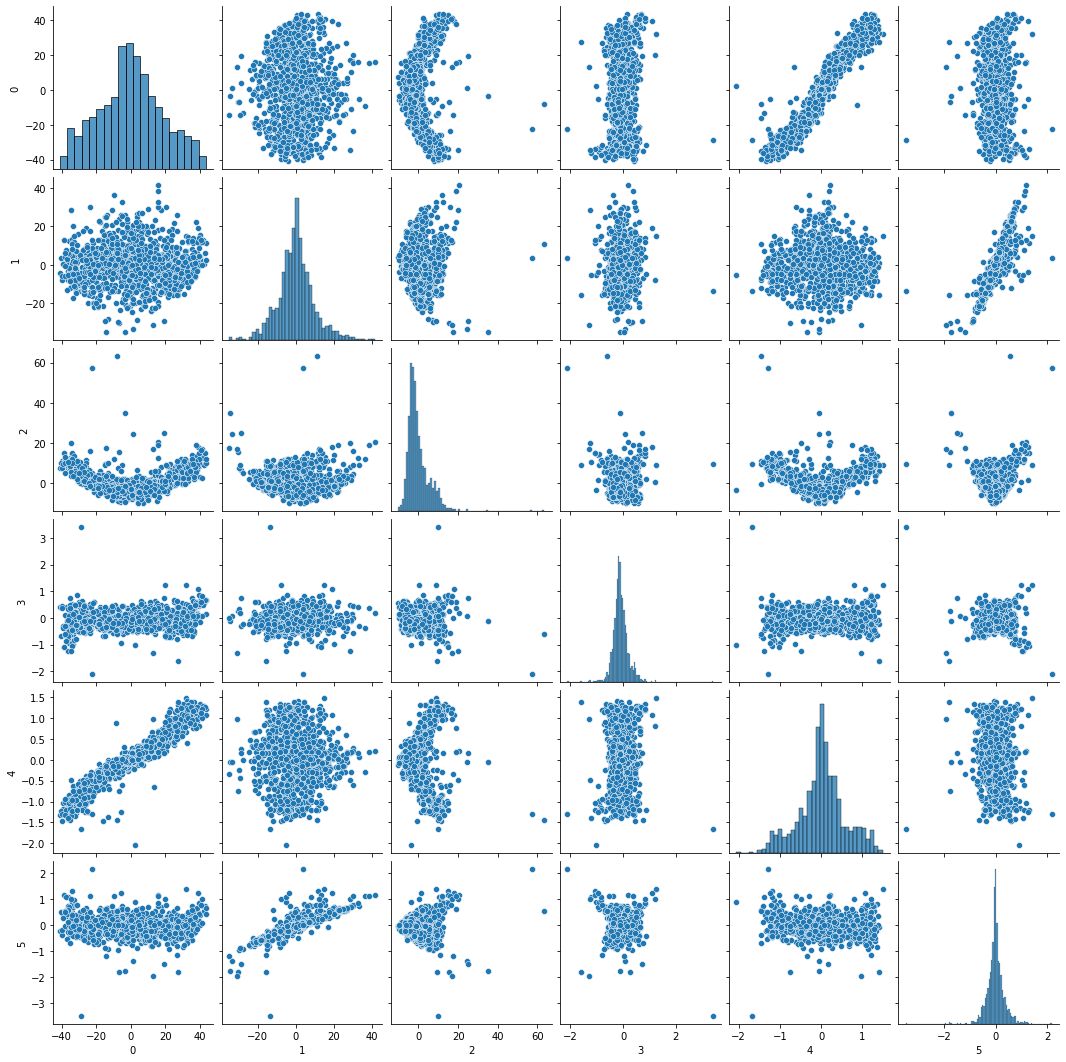

In [11]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.concatenate([Xy_train_c,yy_train.values],axis=1)))

In [12]:
Xrp = rollpitch_df.drop(['yaw','pitch','roll'],axis=1)
yrp = rollpitch_df[['pitch','yaw','roll']]
Xrp_train, Xrp_test, yrp_train, yrp_test = train_test_split(Xrp, yrp, test_size=0.20, random_state=42)
scaler = StandardScaler()
# Xrp_train = scaler.fit_transform(Xrp_train)
# Xrp_test = scaler.transform(Xrp_test)
pca = PCA(0.95)
Xrp_train_c = pca.fit_transform(scaler.fit_transform(Xrp_train))
Xrp_test_c = pca.transform(scaler.transform(Xrp_test))
Xrp_train_c.shape

(1482, 5)

like the previes but here we will see that linear model not better like above but may be used it may be like polynomial models or ensambling like random forest we will see the best in Model section

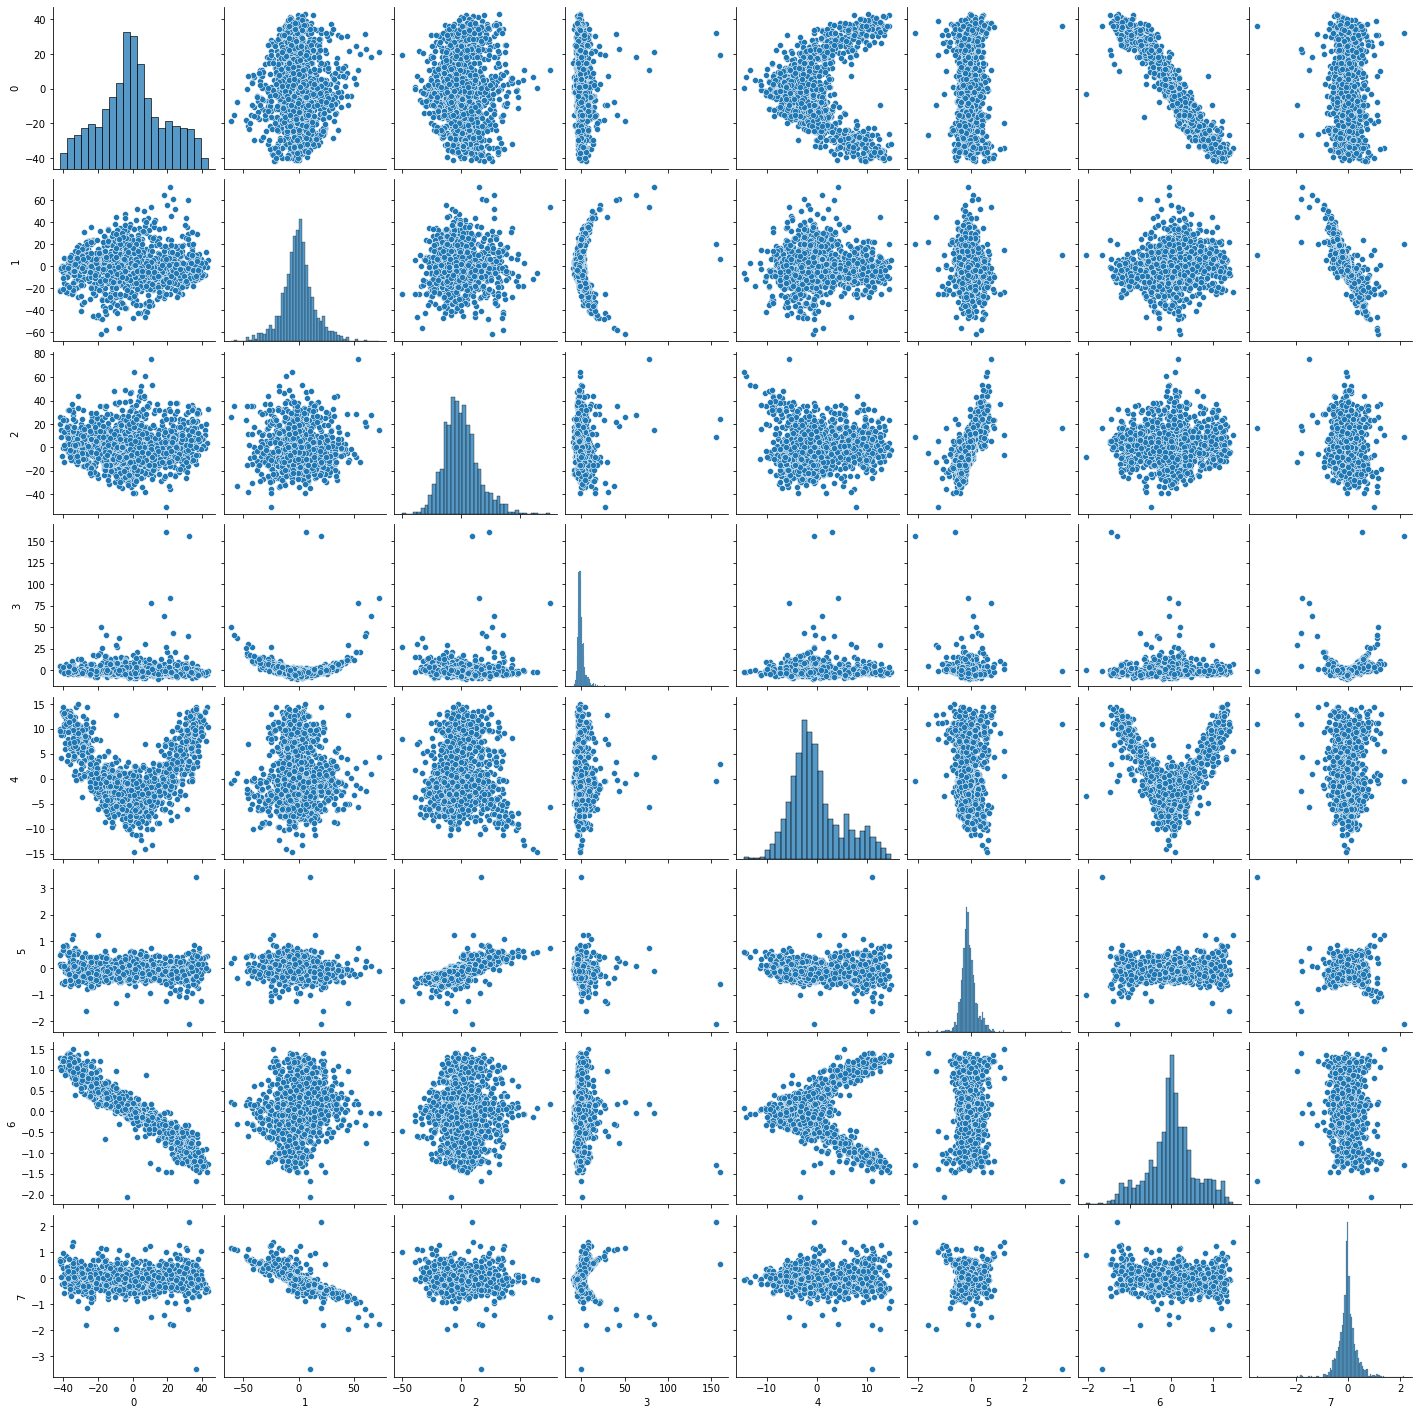

In [13]:
import seaborn as sns
sns.pairplot(pd.DataFrame(np.concatenate([Xrp_train_c,yrp_train.values],axis=1)))

# Models

In [15]:
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor,StackingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer,StandardScaler,RobustScaler

work with MAE as a metric 

from the above plots and understading of the data i will try some linear models and SVR then some ensambl models

In [39]:
regre= MultiOutputRegressor(Ridge(alpha=0.5,solver='sag')).fit(X_train, y_train)
y_pred = regre.predict(X_test)
mean_absolute_error(y_test,y_pred)

0.14860977844274695

In [176]:
regre_svr = MultiOutputRegressor(SVR(C=0.5,gamma=0.05,epsilon=0.001)).fit(X_train, y_train)
y_pred = regre_svr.predict(X_test)
mean_absolute_error(y_test,y_pred)

0.13733781167707476

In [177]:
mse_one = mean_absolute_error(y_test['pitch'], y_pred[:,0])
mse_two = mean_absolute_error(y_test['yaw'], y_pred[:,1])
mse_three = mean_absolute_error(y_test['roll'], y_pred[:,2])
print(f'MAE for first regressor: {mse_one} - second regressor: {mse_two} - Third regressor: {mse_three}')

MAE for first regressor: 0.1664165674583014 - second regressor: 0.10043774539740453 - Third regressor: 0.14515912217551835


In [178]:
import pickle
filename = 'Model.sav'
pickle.dump(regre_svr, open(filename, 'wb'))

In [40]:
regre= MultiOutputRegressor(RandomForestRegressor()).fit(X_train, y_train)
y_pred = regre.predict(X_test)
mean_absolute_error(y_test,y_pred)

0.14543219974598734

In [92]:
regre= MultiOutputRegressor(HistGradientBoostingRegressor()).fit(X_train, y_train)
y_pred = regre.predict(X_test)
mean_absolute_error(y_test,y_pred)

0.14616174370385118

In [95]:
regre = MultiOutputRegressor(XGBRegressor()).fit(X_train, y_train)
y_pred_xg = regre.predict(X_test)
mean_absolute_error(y_test,y_pred_xg)

[09:12:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.14531747714038412

In [98]:
mse_one = mean_absolute_error(y_test['pitch'], y_pred_xg[:,0])
mse_two = mean_absolute_error(y_test['yaw'], y_pred_xg[:,1])
mse_three = mean_absolute_error(y_test['roll'], y_pred_xg[:,2])
print(f'MAE for first regressor: {mse_one} - second regressor: {mse_two} - Third regressor: {mse_three}')

MAE for first regressor: 0.1726895635715382 - second regressor: 0.10754613785168553 - Third regressor: 0.15571672999792865


## yaw models

first i start using Ridge with solver = 'sag' (as i don't need normal equation here) and and the model MAE on test data is 0.15

In [101]:
yaw_regre = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(solver='sag',alpha=0.5))])
yaw_regre.fit(Xy_train_c, yy_train['yaw'])
y_pred = yaw_regre.predict(Xy_test_c)
print('MAE:',mean_absolute_error(yy_test['yaw'], y_pred))

MAE: 0.1521900412496089


In [136]:
yaw_regre = SVR(C=100,epsilon=0.05)
yaw_regre.fit(Xy_train, yy_train['yaw'])
y_pred = yaw_regre.predict(Xy_test)
print('MAE on testing:',mean_absolute_error(yy_test['yaw'], y_pred))
print('MAE on training:',mean_absolute_error(yy_train['yaw'], yaw_regre.predict(Xy_train)))
# SVR(C=6,gamma=0.01,epsilon=0.01)
# SVR(C=100,gamma=0.5, epsilon=0.0001)

MAE on testing: 0.09573654873856914
MAE on training: 0.0549782872865585


In [126]:
import pickle
filename = 'yaw_model_MAE.sav'
pickle.dump(yaw_regre, open(filename, 'wb'))

In [121]:
yaw_regre = RandomForestRegressor(random_state=42,max_depth=35,n_estimators=19)
yaw_regre.fit(Xy_train, yy_train['yaw'])
y_pred = yaw_regre.predict(Xy_test)
print('MAE on testing:',mean_absolute_error(yy_test['yaw'], y_pred))
print('MAE on training:',mean_absolute_error(yy_train['yaw'], yaw_regre.predict(Xy_train)))

MAE on testing: 0.12558935300717533
MAE on testing: 0.03197737538592428


## Pitch Model

In [158]:
pitch_regre = Lasso(alpha=0.01,selection='random')
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('MAE on testing:',mean_absolute_error(y_test['pitch'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['pitch'], pitch_regre.predict(X_train)))

MAE on testing: 0.1991938489979485
MAE on training: 0.11963273986795384


In [159]:
pitch_regre =  Ridge(alpha=0.1,tol=1e-6,solver='saga')
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('MAE on testing:',mean_absolute_error(y_test['pitch'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['pitch'], pitch_regre.predict(X_train)))

MAE on testing: 0.17350444800974654
MAE on training: 0.09648588966082


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [160]:
pitch_regre = SVR(C=1.5,gamma=0.05,epsilon=0.01)
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('MAE on testing:',mean_absolute_error(y_test['pitch'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['pitch'], pitch_regre.predict(X_train)))

MAE on testing: 0.16477443049043797
MAE on training: 0.07549571411090891


In [161]:
import pickle
filename = 'pitch_model_MAE.sav'
pickle.dump(pitch_regre, open(filename, 'wb'))

Try using ensamble models and DecissionTree and these some of the best results i get after some trials 

In [175]:
pitch_regre =  RandomForestRegressor(random_state=42,max_depth=10,n_estimators=100)
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('MAE on testing:',mean_absolute_error(y_test['pitch'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['pitch'], pitch_regre.predict(X_train)))

MAE on testing: 0.1735564988539595
MAE on training: 0.050158036692016586


In [163]:
pitch_regre =  XGBRegressor(n_estimators=40,max_depth=10,reg_lambda=10)
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('MAE on testing:',mean_absolute_error(y_test['pitch'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['pitch'], pitch_regre.predict(X_train)))
# max_depth=10,n_estimators=60,reg_alpha=7,reg_lambda=0.7

[14:42:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE on testing: 0.17684887727092438
MAE on training: 0.04307085505219751


In [164]:
pitch_regre =  DecisionTreeRegressor(random_state=42,max_depth=20,min_samples_leaf=50,max_leaf_nodes=50)
pitch_regre.fit(X_train, y_train['pitch'])
y_pred = pitch_regre.predict(X_test)
print('MAE on testing:',mean_absolute_error(y_test['pitch'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['pitch'], pitch_regre.predict(X_train)))

MAE on testing: 0.19223485526666131
MAE on training: 0.09765497893372466


## roll Model

start with Ridge with default parameters and get 0.35 on testing and after trying alot of lpha values its performance still not good

In [174]:
roll_regre = Ridge(alpha=0.01,solver='sag')
roll_regre.fit(Xrp_train, yrp_train['roll'])
y_pred = roll_regre.predict(Xrp_test)
print('MAE on testing:',mean_absolute_error(yrp_test['roll'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['roll'], roll_regre.predict(Xrp_train)))

MAE on testing: 0.16378794953008574
MAE on training: 0.06899196209401803


In [172]:
roll_regre = SVR(C=6,epsilon=0.001)
roll_regre.fit(Xrp_train, yrp_train['roll'])
y_pred = roll_regre.predict(Xrp_test)
print('MAE on testing:',mean_absolute_error(yrp_test['roll'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['roll'], roll_regre.predict(Xrp_train)))

MAE on testing: 0.14248396238626615
MAE on training: 0.04674977871688269


In [173]:
import pickle
filename = 'roll_model_MAE.sav'
pickle.dump(roll_regre, open(filename, 'wb'))

In [171]:
roll_regre = SVR(C=2.5,epsilon=0.001)
roll_regre.fit(Xrp_train, yrp_train['roll'])
y_pred = roll_regre.predict(Xrp_test)
print('MAE on testing:',mean_absolute_error(yrp_test['roll'], y_pred))
print('MAE on training:',mean_absolute_error(y_train['roll'], roll_regre.predict(Xrp_train)))

MAE on testing: 0.14464551329865769
MAE on training: 0.049143288848159945
